# Nowcasting confidence in job security using Google Trends
## 1. Dataset presentation

In [1]:
import pandas as pd 
import numpy as np 
import datetime
import helpers
import matplotlib.pyplot as plt
import seaborn as sns
FIGSIZE = (12, 6)

df = pd.read_csv('data/probability_dataset.csv', skiprows = 1).drop(columns = ['DK; NA', 'Unnamed: 11'])
df['Date'] = df.Year.apply(str) + "-" +  df.Month.apply(str)
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace = True)
df.index = pd.DatetimeIndex(df.index).to_period('M') # Set periodicity to monthly
df.drop(columns = ['Month', 'Year'], inplace = False) # Do not show month and year, but keep for aggregation

,0%,1-24%,25-49%,50%,51-74%,75-99%,100%,Mean
Date,,,,,,,,
2004-01,39,27,9,15,3,6,1,21.8
2004-02,42,28,8,11,3,5,2,20.2
2004-03,41,27,11,12,2,4,2,20.1
2004-04,37,29,10,13,3,5,2,21.9
2004-05,37,29,11,11,2,7,2,22.3
...,...,...,...,...,...,...,...,...
2020-06,41,27,12,11,2,4,3,20.7
2020-07,37,27,11,12,3,6,4,23.7
2020-08,38,30,11,10,2,5,3,21.4


Respondants were asked: 

"During the next 5 years, what do you think the chances are that you (or
your husband/wife) will lose a job that you wanted to keep ?". 

They were asked to answer an integer from 0 to 100. 

The dataset contains 8 columns. Columns 1 to 7 represent aggregates over certain percentage ranges. The last one is the overall average estimated probability the respondants gave. We will only look at the mean for now. 

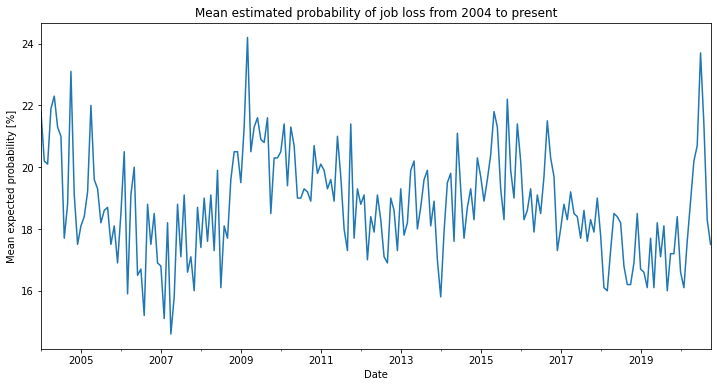

In [2]:
fig, ax = plt.subplots(1, 1, figsize = FIGSIZE) 
df['Mean'].plot()
ax.set_ylabel('Mean expected probability [%]')
ax.set_title('Mean estimated probability of job loss from 2004 to present')
plt.show()

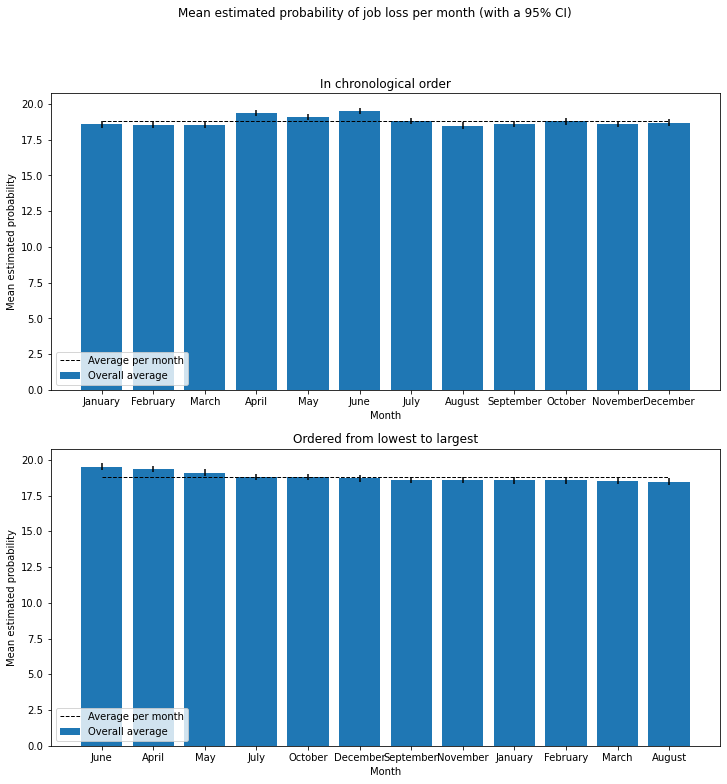

Estimated probability is typically above average in 
	April, May, June
and lower in 
	January, February, March, July, August, September, October, November, December.


In [3]:
months = [datetime.date(2000, m, 1).strftime('%B') for m in range(1, 13)]

monthly_df = df.set_index('Month')
y_error = np.zeros((2, 12))
for i in range(1, 13):
    l, h = helpers.bootstrap(monthly_df.Mean)
    m = np.mean(monthly_df.Mean)
    y_error[0,i-1] = m-l
    y_error[1,i-1] = h-m
    
    


fig, ax = plt.subplots(2, 1, figsize = (FIGSIZE[0], FIGSIZE[1]*2))

monthly_mean = df.groupby('Month').apply(np.mean)['Mean']
t = df.Mean.mean()

ax[0].bar(x = months, height = monthly_mean, yerr = y_error)
ax[0].plot([months[0], months[-1]], [t, t], "k--", linewidth = 1)
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Mean estimated probability')
ax[0].set_title('In chronological order')
ax[0].legend(['Average per month', 'Overall average'])


sorted_order = np.argsort(-monthly_mean) # Sorted opposite to get descening order 
monthly_mean_sorted = np.array(monthly_mean)[sorted_order]
months_sorted = np.array(months)[sorted_order]


ax[1].bar(x = months_sorted, height = monthly_mean_sorted, yerr = y_error)
ax[1].plot([months_sorted[0], months_sorted[-1]], [t, t], "k--", linewidth = 1)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Mean estimated probability')
ax[1].set_title('Ordered from lowest to largest')
ax[1].legend(['Average per month', 'Overall average'])

fig.suptitle("Mean estimated probability of job loss per month (with a 95% CI)")
plt.show()

above = np.array(months)[monthly_mean > t]
below = np.array(months)[monthly_mean <= t]
print('Estimated probability is typically above average in \n\t{}\nand lower in \n\t{}.'.format(', '.join(above), ', '.join(below)))

## 2. Baseline model 
We build a baseline auto-regressive model. This is appropriate, because the time series we are modeling can be assumed to depend linearly on previous terms and on a stochastic term. The most reasonable assumption is that values taken on the previous month and the previous year are the most relevant. The dependence on the previous month allows to explain low frequency evolutions (i.e. the probability at a given month depends on the value at the previous month, meaning doesn't change too sharply in general, just like the economic situation usually changes gradually). The dependency on the previous year is important to account for seasonal changes; we have shown above that the probability has a seasonality, on average peaking in April.

Let $y$ denote the mean estimated probability of job loss.
Then, we model: 
$y_t = \beta_0 + \beta_1 y_{t-1} + \beta_12 y_{t-12} + \epsilon_t \tag{1}$

Let's first see if this logical reasoning is correct by testing which lag terms are statistically significant. We want a familiywise Type I error rate of $\alpha$, and use the Šidák correction for the 13 tests (12 potential terms and intercept): 
$\alpha_{Šidák} = 1 - (1-\alpha)^{\frac{1}{13}} \approx 0.004 \tag{2}$
### 2.1 In-sample fit

In [4]:
from statsmodels.tsa.ar_model import AutoReg

def in_sample_fit(y, lag_terms, use_intercept = True, alpha = None):
    
    if use_intercept: 
        trend_reg = 'c'
    else:
        trend_reg= 'n'
        
    res = AutoReg(df.Mean, lags = lag_terms, trend = trend_reg).fit()
    
    # Create table of parameters
    summary = pd.DataFrame(data = {'Estimate': res.params,
                                      'Standard error': res.bse, 't value': res.tvalues, 
                                      'Pr(>|t|)': res.pvalues})
    rename_dict = {'intercept':'(Intercept)'}
    for k in lag_terms:
        rename_dict['Mean.L{}'.format(k)] = 'lag(y, -{})'.format(k)
        
    summary.rename(index = rename_dict, inplace = True)
    
    if alpha is not None:
        alpha_sidak = 1-(1-alpha)**(1/(len(lag_terms) + 1))
        new_col_name = 'At level {:.6f}'.format(alpha_sidak)
        summary[new_col_name] = summary['Pr(>|t|)'] < alpha_sidak
        summary[new_col_name].replace({True: 'Accepted', False: 'Rejected'}, inplace=True)
        
    return summary

lag_terms = np.arange(1, 13)
in_sample_all = in_sample_fit(df.Mean, lag_terms, use_intercept = True, alpha = 0.05)
in_sample_all

,Estimate,Standard error,t value,Pr(>|t|),At level 0.003938
(Intercept),4.188594,1.648293,2.541171,0.011048,Rejected
"lag(y, -1)",0.343872,0.071557,4.805600,0.000002,Accepted
"lag(y, -2)",0.132966,0.075668,1.757237,0.078877,Rejected
"lag(y, -3)",0.025746,0.074747,0.344442,0.730514,Rejected
"lag(y, -4)",0.106899,0.076705,1.393629,0.163430,Rejected
"lag(y, -5)",-0.081326,0.076377,-1.064800,0.286966,Rejected
"lag(y, -6)",0.230605,0.076654,3.008371,0.002627,Accepted
"lag(y, -7)",0.008414,0.075987,0.110723,0.911836,Rejected
"lag(y, -8)",0.006398,0.075444,0.084809,0.932413,Rejected
"lag(y, -9)",0.070587,0.074967,0.941575,0.346410,Rejected


It turns out that the intercept and the value of from the previous year were not significant. But the value from 6 months ago is. We use these results to modify our model as: 
$y_t = \beta_1 y_{t-1} + \beta_6 y_{t-6} + \epsilon_t \tag{3}$

In [5]:
print("In sample with of the AR model:")
in_sample_all = in_sample_fit(df.Mean, [1, 6], use_intercept = False)
in_sample_all

In sample with of the AR model:


,Estimate,Standard error,t value,Pr(>|t|)
"lag(y, -1)",0.561683,0.053631,10.473151,1.147587e-25
"lag(y, -6)",0.435345,0.053603,8.121725,4.596024e-16


Mean Absolute Error of the AR predictions: 1.1748


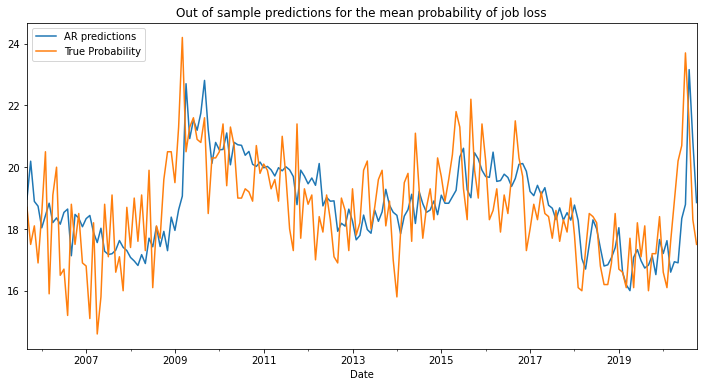

In [6]:
import statsmodels.formula.api as smf

df['Mean_t_1'] = df.Mean.shift(1) 
df['Mean_t_6'] = df.Mean.shift(6)

k = 20 # How to choose k ? Fit gets better the larger k (>= 7) is
# k needs to be large for Trends ot be useful

forecast_start = df.index[k]
for i in range(k, len(df)):    
    mod_base = smf.ols(formula='Mean ~ Mean_t_1 + Mean_t_6', data=df[i-k:i])
    res_base = mod_base.fit()
    df.loc[df.index[i], 'Baseline'] = res_base.predict(df.iloc[i])[0]
    
fig, ax = plt.subplots(1, 1, figsize = FIGSIZE) 
ax.set_title('Out of sample predictions for the mean probability of job loss')
df.Baseline[forecast_start:].plot()
df.Mean[forecast_start:].plot()
ax.legend(['AR predictions', 'True Probability'])

print('Mean Absolute Error of the AR predictions: {:.4f}'.format(helpers.mae(df.Mean, df.Baseline, forecast_start)))

## 3. Using Google Trends

In [7]:
trends = pd.read_csv('data/trends.csv', index_col = 'Date')
trends.index = pd.DatetimeIndex(trends.index).to_period('M')

df_full = pd.merge(df, trends, left_index=True, right_index=True)
df_full.tail()

,Month,Year,0%,1-24%,25-49%,50%,51-74%,75-99%,100%,Mean,Mean_t_1,Mean_t_6,Baseline,Crisis
Date,,,,,,,,,,,,,,
2020-06,6,2020,41,27,12,11,2,4,3,20.7,20.2,18.4,18.336999,52
2020-07,7,2020,37,27,11,12,3,6,4,23.7,20.7,16.6,18.794005,36
2020-08,8,2020,38,30,11,10,2,5,3,21.4,23.7,16.1,23.159129,33
2020-09,9,2020,41,33,8,11,2,3,2,18.3,21.4,17.6,20.838315,39
2020-10,10,2020,47,27,8,10,3,3,2,17.5,18.3,18.9,18.854319,37


### Additional Google Trends Features: Needs to be merged with trends model after discussion
* If covid 19 going to be used: be careful for the start date: Merge accordingly(Or process as the recession period)

In [8]:
covid19trends = pd.read_csv('data/covid19trends.csv')
covid19trends = covid19trends[1:].rename(columns = {"Category: All categories":"covid"})
covid19trends.index = pd.DatetimeIndex(covid19trends.index).to_period('M')
covid19trends[covid19trends.covid == "<1"] = "1"
covid19trends.covid = pd.to_numeric(covid19trends.covid)
covid19trends = covid19trends.groupby(covid19trends.index).sum()
covid19trends

,covid
2019-12,4
2020-01,8
2020-02,16
2020-03,322
2020-04,297
2020-05,265
2020-06,193
2020-07,215
2020-08,236
2020-09,175


In [9]:
jobopp = pd.read_csv('data/jobopportunity.csv')
jobopp = jobopp[1:].rename(columns = {"Category: All categories":"jobOpp"})
jobopp.jobOpp = pd.to_numeric(jobopp.jobOpp)
jobopp

,jobOpp
2004-01,94
2004-02,100
2004-03,62
2004-04,80
2004-05,70
...,...
2020-08,22
2020-09,23
2020-10,25
2020-11,22


In [10]:
unempinsurance = pd.read_csv('data/unempinsurance.csv')
unempinsurance = unempinsurance[1:].rename(columns = {"Category: All categories":"insurance"})
unempinsurance.insurance = pd.to_numeric(unempinsurance.insurance)
unempinsurance

,insurance
2004-01,52
2004-02,45
2004-03,53
2004-04,42
2004-05,35
...,...
2020-08,31
2020-09,23
2020-10,20
2020-11,16


Mean Absolute Error of the predictions: 1.1668


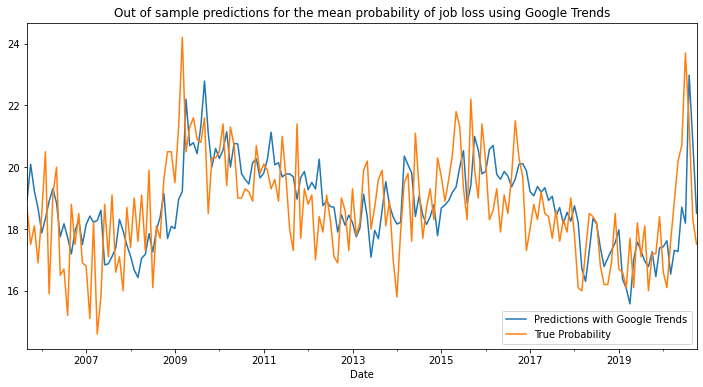

In [11]:
for i in range(k, len(df)):    
    mod_base = smf.ols(formula='Mean ~ Mean_t_1 + Mean_t_6 + Crisis', data=df_full[i-k:i])
    res_base = mod_base.fit()
    df_full.loc[df.index[i], 'Trends'] = res_base.predict(df_full.iloc[i])[0]
    
fig, ax = plt.subplots(1, 1, figsize = FIGSIZE) 
ax.set_title('Out of sample predictions for the mean probability of job loss using Google Trends')
df_full.Trends[forecast_start:].plot()
df_full.Mean[forecast_start:].plot()
ax.legend(['Predictions with Google Trends', 'True Probability'])

print('Mean Absolute Error of the predictions: {:.4f}'.format(helpers.mae(df_full.Mean, df_full.Trends, forecast_start)))

<AxesSubplot:title={'center':'Google Trends Monthly Data Points'}, xlabel='date'>

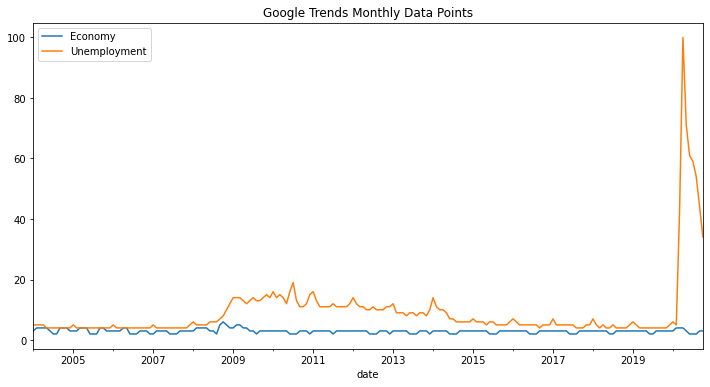

In [87]:
from pytrends.request import TrendReq


totalTrend = TrendReq(hl='en-US', tz=360)

# Keywords to search
kw_list = ["Economy", "Unemployment"]  
_cat = 0 # see https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories to choose categories

_geo = 'US' # Only in US
_gprop = '' # Default to web searches

# Build payload request to get data from Google trends
start, end = str(df.index[0].to_timestamp()).split(' ')[0], str(df.index[-1].to_timestamp()).split(' ')[0]
_timeframe = '{:s} {:s}'.format(start, end)

totalTrend.build_payload(kw_list, cat=_cat, timeframe=_timeframe, geo=_geo, gprop=_gprop)

# Get interest over time
# Capture Monthly Data for use in Normalization against Weekly
pytrends_df = totalTrend.interest_over_time()
pytrends_df.drop(columns ='isPartial', inplace = True)
pytrends_df.index = pd.DatetimeIndex(pytrends_df.index).to_period('M')

# Plot the Interest
pytrends_df.plot(title='Google Trends Monthly Data Points', figsize=FIGSIZE)

In [88]:
df_full2 = pd.merge(df, pytrends_df, left_index=True, right_index=True)
df_full2.tail()

,Month,Year,0%,1-24%,25-49%,50%,51-74%,75-99%,100%,Mean,Mean_t_1,Mean_t_6,Baseline,Economy,Unemployment
Date,,,,,,,,,,,,,,,
2020-06,6,2020,41,27,12,11,2,4,3,20.7,20.2,18.4,18.336999,2,61
2020-07,7,2020,37,27,11,12,3,6,4,23.7,20.7,16.6,18.794005,2,59
2020-08,8,2020,38,30,11,10,2,5,3,21.4,23.7,16.1,23.159129,2,54
2020-09,9,2020,41,33,8,11,2,3,2,18.3,21.4,17.6,20.838315,3,44
2020-10,10,2020,47,27,8,10,3,3,2,17.5,18.3,18.9,18.854319,3,34


Mean Absolute Error of the predictions: 1.1629


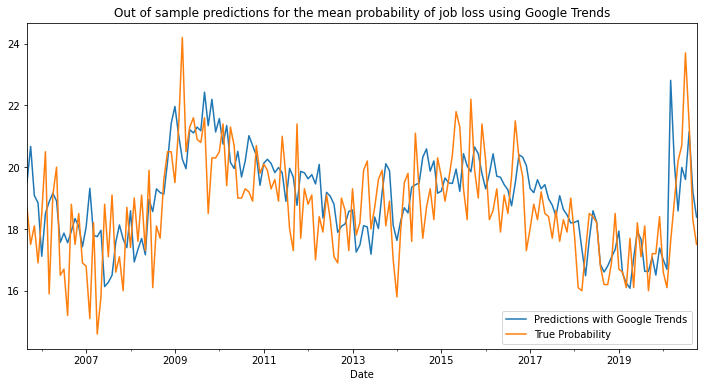

In [90]:
for i in range(k, len(df_full2)):    
    mod_base = smf.ols(formula='Mean ~ Mean_t_1 + Mean_t_6 + Economy + Unemployment', data=df_full2[i-k:i])
    res_base = mod_base.fit()
    df_full2.loc[df.index[i], 'Trends'] = res_base.predict(df_full2.iloc[i])[0]
    
fig, ax = plt.subplots(1, 1, figsize = FIGSIZE) 
ax.set_title('Out of sample predictions for the mean probability of job loss using Google Trends')
df_full2.Trends[forecast_start:].plot()
df_full2.Mean[forecast_start:].plot()
ax.legend(['Predictions with Google Trends', 'True Probability'])

print('Mean Absolute Error of the predictions: {:.4f}'.format(helpers.mae(df_full2.Mean, df_full2.Trends, forecast_start)))